<a href="https://colab.research.google.com/github/aliciafmachado/artgan_implementation/blob/master/artgan_wikiart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# where we will save the training nets
%cd "gdrive/My Drive/Deep_Learning_Dataset/"
%ls

/content/gdrive/My Drive/Deep_Learning_Dataset
num_folder/  style_v1/  wikiart/


In [0]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torchvision import transforms, utils
import random
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import * 
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# Training using wikiart dataset
class_dataset = "style" # style - artist - genre
version = 1 # number of the version
num_classes = 27 # style: 27 - artist: 23 - genre: 10

num_folder = class_dataset + "_v" + str(version)
# Check if you are in the folder Deep_Learning_Dataset
if not os.path.exists(num_folder):
    os.makedirs(num_folder)

In [0]:
class WikiartDataset(Dataset):

    def __init__(self, type, file, dir, mode, transform):
        """
        :param type: 0: Style, 1: Genre, 2: Artist
        :param file: .csv file that contains the path and classification
        :param dir: directory of the image files
        :param mode: 'Train' or 'Test'
        :param transform: image transformation
        """
        self.type = type
        self.dir = dir
        self.df = pd.read_csv(os.path.join(self.dir, file), header=None, names=["file", "label"])
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __str__(self):
        text = "Type: "
        if self.type == 0:
            text += "Style"
        elif self.type == 1:
            text += "Genre"
        elif self.type == 2:
            text += "Artist"
        text += ", mode: "
        text += self.mode
        text += ", number of files: "
        text += str(len(self.df))
        return text

    def __getitem__(self, idx):
        file = self.df.loc[idx, "file"]
        label = self.df.loc[idx, "label"]
        print(self.dir)
        print(file)
        img = Image.open(os.path.join(self.dir, file))
        img = self.transform(img)
        return img, label

In [0]:
transform = transforms.Compose(
    [
     transforms.Resize(64),
     transforms.ToTensor(),
])

# Choice of kind of dataset

trainset_wikiart = WikiartDataset(0,"style_train.csv","wikiart/",'Train',transform)

batch_size = 128

trainloader_wikiart = torch.utils.data.DataLoader(trainset_wikiart,batch_size=batch_size,shuffle=True)

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader_wikiart)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(trainset_wikiart)
print()
print(trainset_wikiart[0][0].size())

KeyboardInterrupt: ignored

In [11]:
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(trainset_wikiart)
print()
print(trainset_wikiart[0][0].size())

OSError: ignored

Files already downloaded and verified
Files already downloaded and verified


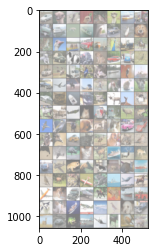

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

torch.Size([3, 64, 64])


In [0]:
#CIFAR-10
torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(64),
     transforms.ToTensor(),
])
     

batch_size = 128

trainset_CIFAR10 = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
trainloader_CIFAR10 = torch.utils.data.DataLoader(trainset_CIFAR10,batch_size=batch_size,shuffle=True,num_workers=2)

testset_CIFAR10 = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
testloader_CIFAR10 = torch.utils.data.DataLoader(testset_CIFAR10,batch_size=batch_size,shuffle=True,num_workers=2)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_CIFAR10)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(trainset_CIFAR10)
print()
print(trainset_CIFAR10[0][0].size())

In [0]:
# Util functions

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'fake')

def gen_noise(batch_size, epoch):
  return torch.normal(0.0, 0.1/(epoch+1), (batch_size, 3, 64, 64))

def gen_z(batch_size, d):
  return torch.randn(batch_size, d)

def gen_yk(batch_size, num_classes):
  t = torch.zeros(batch_size, num_classes)
  for i, row in enumerate(t):
    num = random.randint(0, num_classes-1)
    # num = i % num_classes
    row[num] = 1
  return t

def fake_v(batch_size, num_classes):
  v = torch.zeros(batch_size) + num_classes
  return v

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=80):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

def gen_y_test(test_num=10):
    # defined only for multiple of 10
    z = torch.randn(test_num, 100) 
    y = torch.zeros(test_num, 10)
    l = []
    for i, row in enumerate(y):
      row[i % 10] = 1
      l.append(i % 10)
    return torch.cat([z,y],1).type(torch.cuda.FloatTensor), l

def save_img(G, D, epoch, test_num=20):
  G.eval()
  D.eval()
  path_img = "CIFAR10_images/epoch_" + str(epoch)
  if not os.path.exists(path_img):
      os.makedirs(path_img)

  y, l = gen_y_test(test_num=test_num)
  imgs = G(y)
  output = D(imgs)
  probs, predicted = torch.max(output.data, 1)

  z = zip(l, imgs, probs, predicted)
  for i, values in enumerate(z):
    label, img_solo, p, pred = values
    print()
    print("Image %d" %i)
    npimg = img_solo.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    path_img_save = path_img + "/Image_"+str(i)+"_"+classes[label]+"_"+classes[pred.item()]+".jpg"
    plt.savefig(path_img_save)
    plt.show()
    print("label = {} ({})".format(classes[label], label))
    print("Calculated label by D = {} ({}) -> Prob = {:02.1f}".format(classes[pred.item()], pred.item(), 100*p))
    
  G.train()
  D.train()

In [0]:
# ARTGAN neural network implementation
# Generator layers

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class zNet(nn.Module):
    # TODO: ARRUMAR AQUI INPUT_SIZE
    # Where dense code is transformed to latent code
    def __init__(self, input_size=110):
        """
        zNet Constructor
        :param input_size: size of Y + Z
        :param output_size: size of the image after its transformed to latent code
        :param output_dim: size of the dimension after its transformed to latent code
        :output: Latent code 1024 x 4 x 4
        """
        super(zNet, self).__init__()
        self.input_size = input_size       
        self.deconv1 = nn.ConvTranspose2d(self.input_size, 1024, 4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        
    def forward(self, out):
        out = out.view(-1, self.input_size, 1, 1)
        out = F.relu(self.bn1(self.deconv1(out)))
        out = F.relu(self.bn2(self.deconv2(out)))
        return out


class Dec(nn.Module):
    # Latent code is upsampled via
    # deconvolution to image space
    def __init__(self):
        """
        :param input_dim: dimension of the code after zNet
        :output: Image 3 x 64 x 64
        """
        super(Dec, self).__init__()
        self.deconv3 = nn.ConvTranspose2d( 512, 256, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d( 256, 128, 4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d( 128, 128, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.deconv6 = nn.ConvTranspose2d( 128,   3, 4, stride=2, padding=1)

    def forward(self, out):
        out = F.relu(self.bn3(self.deconv3(out)))
        out = F.relu(self.bn4(self.deconv4(out)))
        out = F.relu(self.bn5(self.deconv5(out)))
        out = torch.sigmoid(self.deconv6(out))
        return out


class Generator(nn.Module):
    # G layers
    def __init__(self, znet, dec):
        """
        :param znet: ZNet
        :param dec: Decoder
        """
        super(Generator, self).__init__()
        self.znet = znet
        self.dec = dec

    def forward(self, out):
        """
        :param x: Torch array of size 4096
        :return: Image 3 x 64 x 64
        """
        out = self.znet(out)
        out = self.dec(out)
        return out

In [0]:
# ARTGAN neural network implementation
# Discriminator layers

import torch
import torch.nn as nn
import numpy as np


class clsNet(nn.Module):
    # Latent features is used for classification
    def __init__(self, num_classes=10):
        """
        :param input_size: size of the output torch array of the Encoder
        :param num_classes: Classification into num_classes + 1 classes (the last one is a fake class)
        """
        super(clsNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(512, 1024, 4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.linear = nn.Sequential(
            nn.Linear(16384, num_classes+1),
            nn.Sigmoid()
        )

    def forward(self, out):
        out = self.features(out)
        out = out.view(out.size(0), -1) 
        out = self.linear(out)
        return out


class Enc(nn.Module):
    # Image is enconded via convolution
    # to latent features
    def __init__(self):
        """
        :param input_dim: Dimension of the image (3 x 64 x 64)
        :param output_size: size of the output torch array
        """
        super(Enc, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, out):
        out = self.features(out)
        return out


class Discriminator(nn.Module):

    def __init__(self, clsnet, enc):
        """
        :param clsnet: clsNet
        :param enc: Encoder
        """
        super(Discriminator, self).__init__()
        self.clsnet = clsnet
        self.enc = enc

    def forward(self, x):
        """
        :param x: Image 3 x 64 x 64
        :return: Torch array of size K+1 (number of classes)
        """
        out = self.enc(x)
        out = self.clsnet(out)
        return out

In [0]:
class ArtGAN:

    def __init__(self,
                 img_size=64,
                 input_dim_enc=3,
                 z_dim=100,
                 num_classes=10,
                 out_dim_zNet=1024,
                 G=None,
                 D=None):
        """
        ArtGAN constructor
        :param img_size:
        :param input_dim:
        :param z_dim:
        :param num_classes:
        """
        if G is None and D is None: 
          # Inputs
          self.img_size = img_size
          self.input_dim_enc = input_dim_enc # usually 3
          self.num_classes = num_classes
          self.out_dim_zNet = out_dim_zNet
          self.out_size_zNet = int(self.img_size/2**4)
          self.z_dim = z_dim
          self.out_size_enc = int(self.out_dim_zNet * self.out_size_zNet ** 2)
          if z_dim is None:
              self.z_dim = self.out_size_enc - self.num_classes
          # Nets
          self.znet = zNet(input_size=self.z_dim + self.num_classes)
          self.clsnet = clsNet(num_classes=self.num_classes)
          self.enc = Enc()
          self.dec = Dec()
          self.D = Discriminator(self.clsnet, self.enc)
          self.G = Generator(self.znet, self.dec)

        else:
          # Inputs
          self.img_size = img_size
          self.input_dim_enc = input_dim_enc # usually 3
          self.num_classes = num_classes
          self.out_dim_zNet = out_dim_zNet
          self.out_size_zNet = int(self.img_size/2**4)
          self.z_dim = z_dim
          self.out_size_enc = int(self.out_dim_zNet * self.out_size_zNet ** 2)
          if z_dim is None:
              self.z_dim = self.out_size_enc - self.num_classes
          self.G = G
          self.D = D
          
    def cuda(self):
        
        self.D.cuda()
        self.G.cuda()

    def train(self, trainloader, testloader, epochs=10,
              img_interval=1, batch_size=64, cuda=True, initial_epoch=0):
        """
        Training function
        :param optimizers: used optimizers (2 entries)
        :param criterions: loss functions (3 entries)
        :param trainloader: dataset in batch
        :param testloader: testset in batch
        :param epochs: epochs
        :param batch_size: batch_size
        :param img_interval: interval for showing the images produced
        :param cuda: usage of gpu
        :return: Loss list, accuracy list
        """

        lr_init = 0.001
        
        g_opt = torch.optim.RMSprop(self.G.parameters(), lr=lr_init, alpha=0.9)
        d_opt = torch.optim.RMSprop(self.D.parameters(), lr=lr_init, alpha=0.9)

        # To evaluate how our net is learning
        fixed_noise = gen_z(1, self.z_dim)
        y_k_fixed = gen_yk(1, self.num_classes)

        pd_loss = pd.DataFrame(columns=['epoch', 'd_loss', 'g_loss'])
        path_loss = "CIFAR10_loss/loss1.csv"
        pd_loss.to_csv(path_loss, index=False)

        for epoch in range(initial_epoch, epochs):
            # Save loss
            g_loss_l = []
            d_loss_l = []

            # Decay in the learning rate
            d_opt = exp_lr_scheduler(d_opt, epoch)
            g_opt = exp_lr_scheduler(g_opt, epoch)

            # import tqdm
            for i, data in enumerate(tqdm(trainloader), 0):
        
                # zero grad
                d_opt.zero_grad()
                # get the inputs
                x_r, k = data
                b_s = len(k)
                # noise
                x_noise = gen_noise(b_s, epoch)
                x_r += x_noise
                # generate z_hat
                z_hat = gen_z(b_s, self.z_dim)
                #print("z_hat = ", z_hat.size())
                # generate Y_k and its label
                y_k = gen_yk(b_s, self.num_classes)
                #print("y_k = ", y_k.size())
                # gen fakes
                y_fake = fake_v(b_s, self.num_classes)
                #print("y_fake = ", y_fake.size())
                if cuda:
                    y_k = y_k.type(torch.cuda.FloatTensor)
                    x_r = x_r.type(torch.cuda.FloatTensor)
                    k = k.type(torch.cuda.LongTensor)
                    z_hat = z_hat.type(torch.cuda.FloatTensor)
                    y_k = y_k.type(torch.cuda.FloatTensor)
                # calculate X_hat
                in_G = torch.cat([z_hat, y_k.type(torch.cuda.FloatTensor)], 1)
                k_hot = F.one_hot(k, self.num_classes + 1)
                #print("k_hot = ", k_hot.size())
                y_k_hot = F.one_hot(y_fake.type(torch.int64), self.num_classes + 1)
                #print("y_k_hot = ", y_k_hot.size())
                # calculate Y
                y = self.D(x_r)
                # Calculate Y_hat
                x_hat = self.G(in_G)
                y_hat = self.D(x_hat)
                # update D
                d_real_loss = F.binary_cross_entropy(y, k_hot.type(torch.cuda.FloatTensor))
                d_fake_loss = F.binary_cross_entropy(y_hat, y_k_hot.type(torch.cuda.FloatTensor))
                d_loss = d_real_loss + d_fake_loss
                d_loss_l.append(d_loss.item())
                d_loss.backward(retain_graph=True)
                d_opt.step()

                # zero grad
                g_opt.zero_grad()

                # adversarial loss
                new_y_hat = self.D(x_hat)
                #print("new_y_hat = ", new_y_hat.size())
                new_y_k_hot = torch.cat([y_k.type(torch.cuda.FloatTensor), torch.zeros(b_s,1).type(torch.cuda.FloatTensor)],1)
                #print("new_y_k_hot = ", new_y_k_hot.size())
                g_loss_adv = F.binary_cross_entropy(new_y_hat, new_y_k_hot)

                # L2 loss
                # calculate z
                z = self.D.enc(x_r)
                #print("z = ", z.size()) 
                # calculate X_hat_z
                x_hat_z = self.G.dec(z)
                g_loss_l2 = torch.mean((x_hat_z - x_r) ** 2)
                
                # + g_loss_adv
                g_loss = g_loss_l2 + g_loss_adv
                g_loss.backward()
                g_loss_l.append(g_loss.item())  
                g_opt.step()

            d = {'epoch': epoch, 'd_loss': d_loss_l, 'g_loss': g_loss_l}
            pd_loss = pd.read_csv(path_loss)
            pd_loss = pd_loss.append(pd.DataFrame(data=d), ignore_index=True)
            pd_loss.to_csv(path_loss, index=False)

            # print image
            if((epoch + 1) % img_interval == 0):
                save_img(self.G, self.D, epoch)
                name_net = "CIFAR10_net/nn_" + str(epoch) + ".pt"
                torch.save({'epoch': epoch,
                          'G': self.G.state_dict(),
                          'D': self.D.state_dict(),
                          'opt_G': g_opt.state_dict(),
                          'opt_D': d_opt.state_dict(),
                          }, name_net)
        return d_loss_l, g_loss_l

In [0]:
net = ArtGAN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()

using cuda


In [0]:
summary(net.G, input_size=(110, 1 ,1), batch_size=64)
summary(net.D, input_size=(3, 64 ,64), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [64, 1024, 4, 4]       1,803,264
       BatchNorm2d-2           [64, 1024, 4, 4]           2,048
   ConvTranspose2d-3            [64, 512, 8, 8]       8,389,120
       BatchNorm2d-4            [64, 512, 8, 8]           1,024
              zNet-5            [64, 512, 8, 8]               0
   ConvTranspose2d-6          [64, 256, 16, 16]       2,097,408
       BatchNorm2d-7          [64, 256, 16, 16]             512
   ConvTranspose2d-8          [64, 128, 32, 32]         524,416
       BatchNorm2d-9          [64, 128, 32, 32]             256
  ConvTranspose2d-10          [64, 128, 32, 32]         147,584
      BatchNorm2d-11          [64, 128, 32, 32]             256
  ConvTranspose2d-12            [64, 3, 64, 64]           6,147
              Dec-13            [64, 3, 64, 64]               0
Total params: 12,972,035
Trainable para

LR is set to 0.001
LR is set to 0.001




Image 0


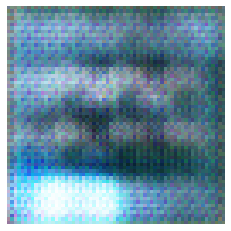

label = plane (0)
Calculated label by D = fake (10) -> Prob = 36.5

Image 1


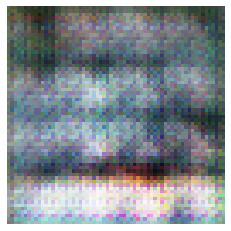

label = car (1)
Calculated label by D = fake (10) -> Prob = 71.7

Image 2


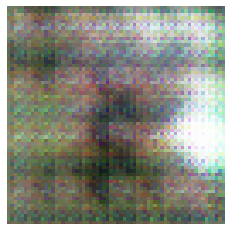

label = bird (2)
Calculated label by D = fake (10) -> Prob = 64.5

Image 3


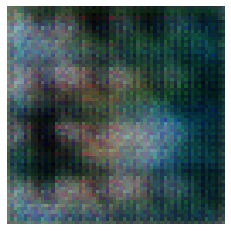

label = cat (3)
Calculated label by D = fake (10) -> Prob = 59.8

Image 4


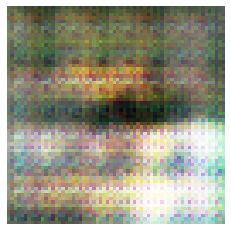

label = deer (4)
Calculated label by D = fake (10) -> Prob = 73.9

Image 5


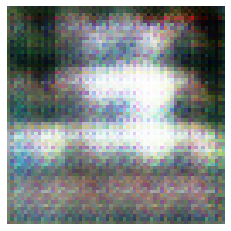

label = dog (5)
Calculated label by D = fake (10) -> Prob = 64.3

Image 6


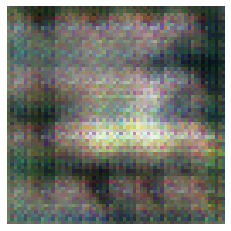

label = frog (6)
Calculated label by D = fake (10) -> Prob = 71.5

Image 7


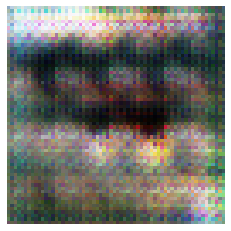

label = horse (7)
Calculated label by D = fake (10) -> Prob = 71.4

Image 8


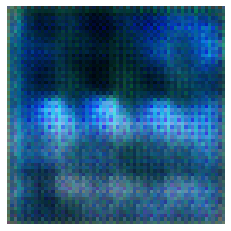

label = ship (8)
Calculated label by D = plane (0) -> Prob = 100.0

Image 9


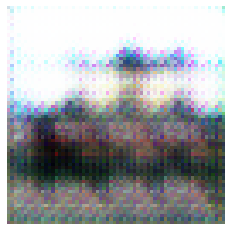

label = truck (9)
Calculated label by D = fake (10) -> Prob = 72.5

Image 10


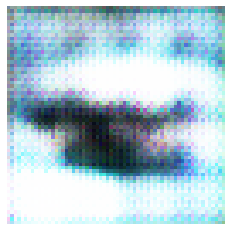

label = plane (0)
Calculated label by D = fake (10) -> Prob = 78.4

Image 11


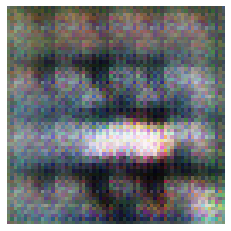

label = car (1)
Calculated label by D = fake (10) -> Prob = 75.8

Image 12


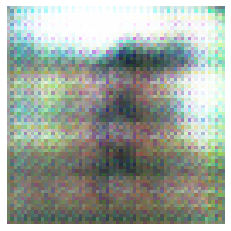

label = bird (2)
Calculated label by D = fake (10) -> Prob = 70.5

Image 13


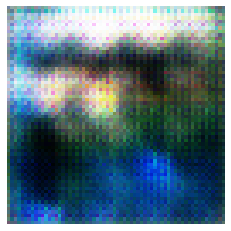

label = cat (3)
Calculated label by D = ship (8) -> Prob = 98.1

Image 14


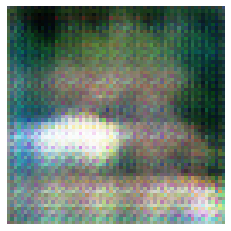

label = deer (4)
Calculated label by D = fake (10) -> Prob = 70.7

Image 15


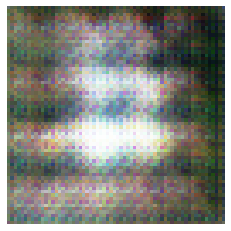

label = dog (5)
Calculated label by D = fake (10) -> Prob = 68.0

Image 16


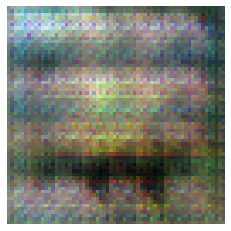

label = frog (6)
Calculated label by D = fake (10) -> Prob = 75.9

Image 17


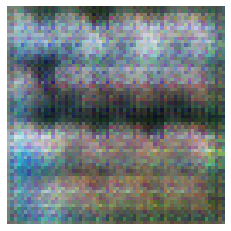

label = horse (7)
Calculated label by D = fake (10) -> Prob = 71.6

Image 18


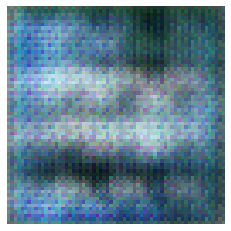

label = ship (8)
Calculated label by D = fake (10) -> Prob = 76.1

Image 19


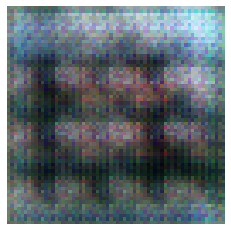

label = truck (9)
Calculated label by D = fake (10) -> Prob = 72.9
LR is set to 0.001
LR is set to 0.001




Image 0


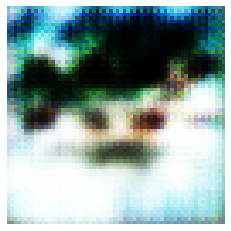

label = plane (0)
Calculated label by D = fake (10) -> Prob = 87.9

Image 1


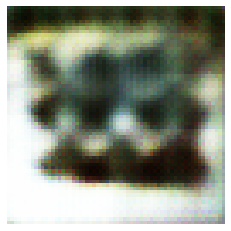

label = car (1)
Calculated label by D = fake (10) -> Prob = 75.3

Image 2


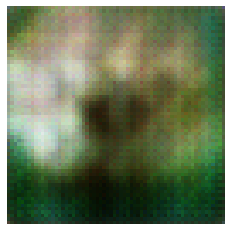

label = bird (2)
Calculated label by D = fake (10) -> Prob = 62.5

Image 3


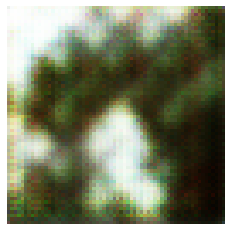

label = cat (3)
Calculated label by D = fake (10) -> Prob = 77.3

Image 4


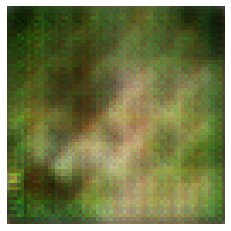

label = deer (4)
Calculated label by D = fake (10) -> Prob = 74.9

Image 5


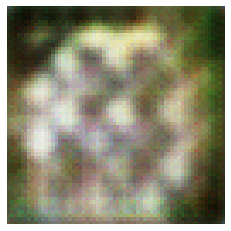

label = dog (5)
Calculated label by D = fake (10) -> Prob = 49.4

Image 6


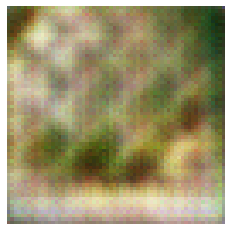

label = frog (6)
Calculated label by D = fake (10) -> Prob = 73.4

Image 7


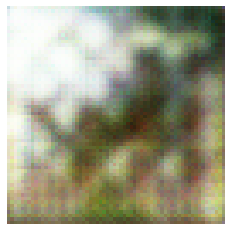

label = horse (7)
Calculated label by D = fake (10) -> Prob = 53.0

Image 8


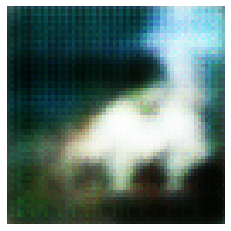

label = ship (8)
Calculated label by D = fake (10) -> Prob = 71.8

Image 9


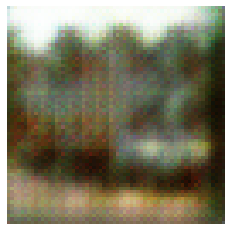

label = truck (9)
Calculated label by D = fake (10) -> Prob = 68.3

Image 10


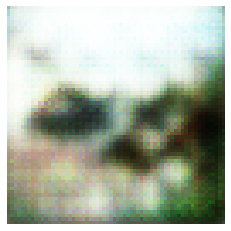

label = plane (0)
Calculated label by D = fake (10) -> Prob = 43.6

Image 11


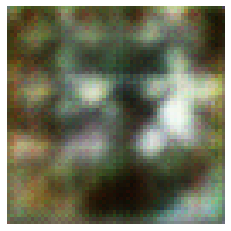

label = car (1)
Calculated label by D = fake (10) -> Prob = 66.0

Image 12


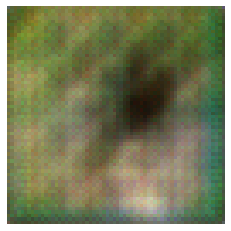

label = bird (2)
Calculated label by D = fake (10) -> Prob = 77.2

Image 13


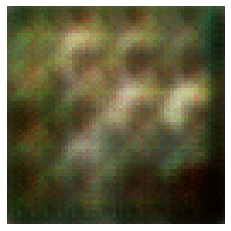

label = cat (3)
Calculated label by D = fake (10) -> Prob = 55.7

Image 14


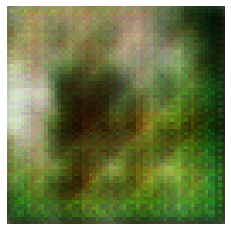

label = deer (4)
Calculated label by D = fake (10) -> Prob = 71.2

Image 15


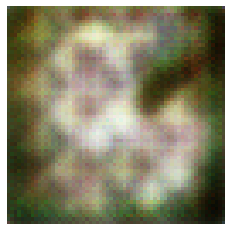

label = dog (5)
Calculated label by D = fake (10) -> Prob = 54.6

Image 16


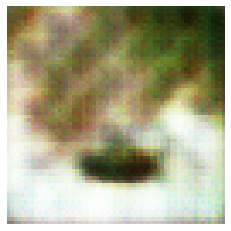

label = frog (6)
Calculated label by D = fake (10) -> Prob = 81.6

Image 17


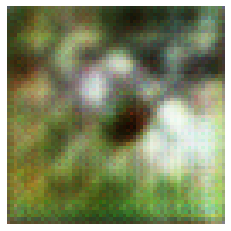

label = horse (7)
Calculated label by D = fake (10) -> Prob = 84.9

Image 18


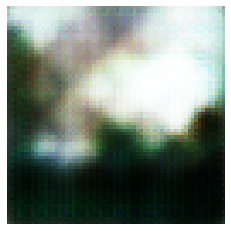

label = ship (8)
Calculated label by D = fake (10) -> Prob = 56.0

Image 19


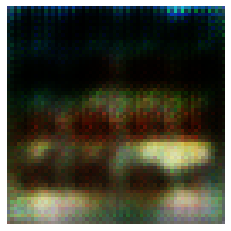

label = truck (9)
Calculated label by D = fake (10) -> Prob = 74.2
LR is set to 0.001
LR is set to 0.001




Image 0


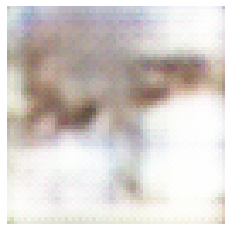

label = plane (0)
Calculated label by D = dog (5) -> Prob = 28.6

Image 1


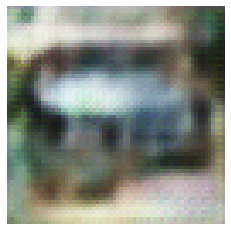

label = car (1)
Calculated label by D = car (1) -> Prob = 24.2

Image 2


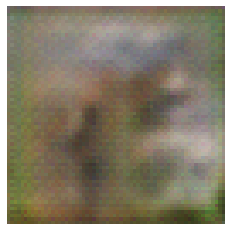

label = bird (2)
Calculated label by D = fake (10) -> Prob = 34.4

Image 3


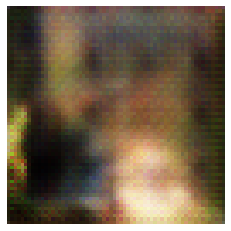

label = cat (3)
Calculated label by D = cat (3) -> Prob = 50.0

Image 4


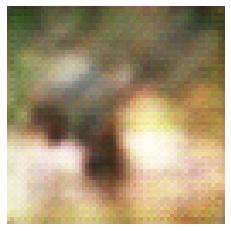

label = deer (4)
Calculated label by D = fake (10) -> Prob = 33.0

Image 5


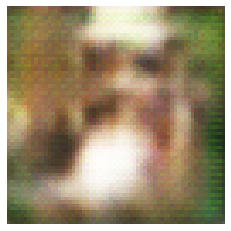

label = dog (5)
Calculated label by D = dog (5) -> Prob = 64.7

Image 6


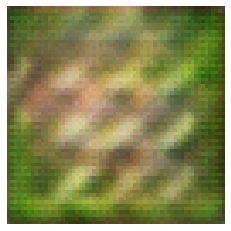

label = frog (6)
Calculated label by D = fake (10) -> Prob = 35.9

Image 7


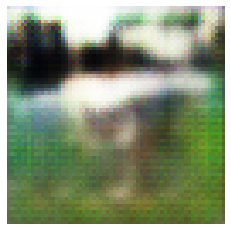

label = horse (7)
Calculated label by D = fake (10) -> Prob = 33.2

Image 8


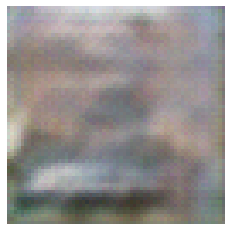

label = ship (8)
Calculated label by D = ship (8) -> Prob = 35.1

Image 9


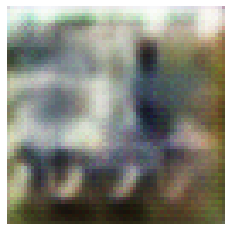

label = truck (9)
Calculated label by D = truck (9) -> Prob = 46.5

Image 10


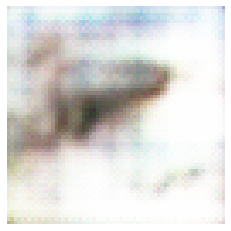

label = plane (0)
Calculated label by D = dog (5) -> Prob = 19.7

Image 11


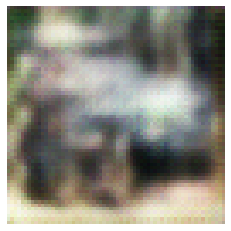

label = car (1)
Calculated label by D = fake (10) -> Prob = 27.5

Image 12


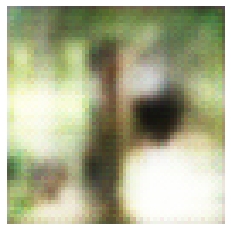

label = bird (2)
Calculated label by D = fake (10) -> Prob = 28.6

Image 13


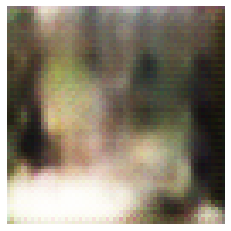

label = cat (3)
Calculated label by D = fake (10) -> Prob = 40.9

Image 14


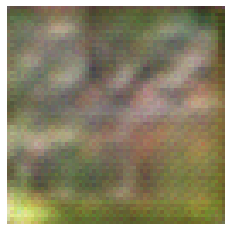

label = deer (4)
Calculated label by D = fake (10) -> Prob = 50.2

Image 15


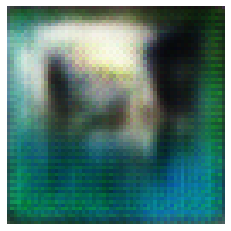

label = dog (5)
Calculated label by D = plane (0) -> Prob = 100.0

Image 16


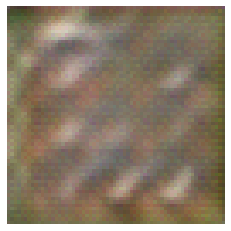

label = frog (6)
Calculated label by D = cat (3) -> Prob = 31.6

Image 17


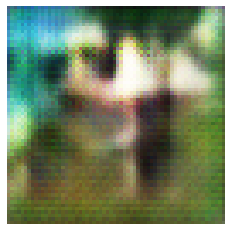

label = horse (7)
Calculated label by D = dog (5) -> Prob = 71.7

Image 18


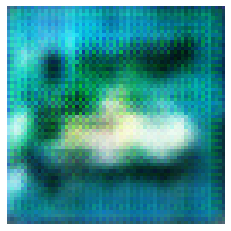

label = ship (8)
Calculated label by D = plane (0) -> Prob = 100.0

Image 19


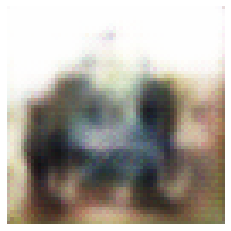

label = truck (9)
Calculated label by D = fake (10) -> Prob = 37.3
LR is set to 0.001
LR is set to 0.001




Image 0


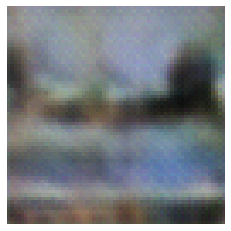

label = plane (0)
Calculated label by D = fake (10) -> Prob = 73.7

Image 1


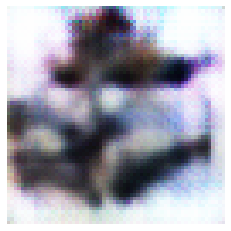

label = car (1)
Calculated label by D = fake (10) -> Prob = 49.9

Image 2


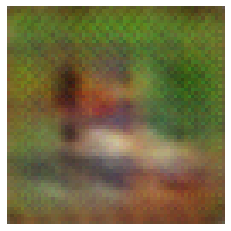

label = bird (2)
Calculated label by D = fake (10) -> Prob = 67.2

Image 3


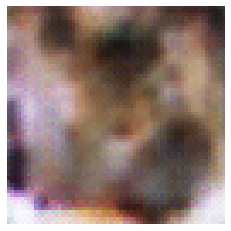

label = cat (3)
Calculated label by D = fake (10) -> Prob = 59.6

Image 4


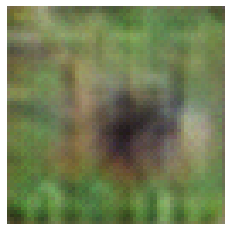

label = deer (4)
Calculated label by D = fake (10) -> Prob = 65.0

Image 5


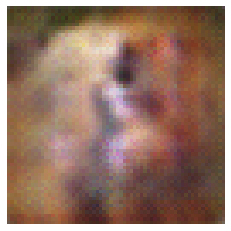

label = dog (5)
Calculated label by D = fake (10) -> Prob = 60.1

Image 6


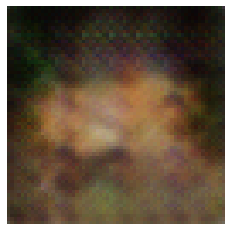

label = frog (6)
Calculated label by D = fake (10) -> Prob = 52.9

Image 7


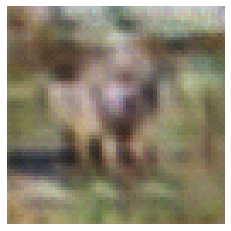

label = horse (7)
Calculated label by D = fake (10) -> Prob = 71.7

Image 8


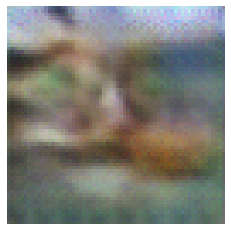

label = ship (8)
Calculated label by D = fake (10) -> Prob = 74.7

Image 9


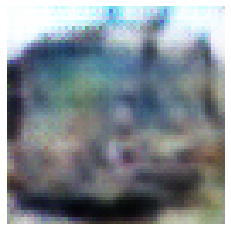

label = truck (9)
Calculated label by D = fake (10) -> Prob = 53.6

Image 10


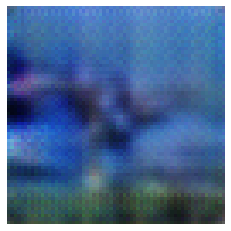

label = plane (0)
Calculated label by D = fake (10) -> Prob = 84.2

Image 11


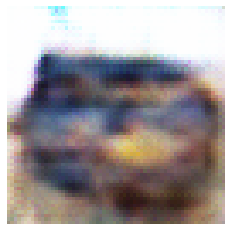

label = car (1)
Calculated label by D = fake (10) -> Prob = 78.4

Image 12


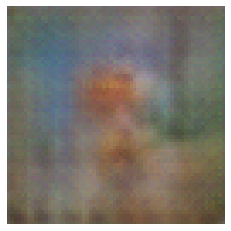

label = bird (2)
Calculated label by D = fake (10) -> Prob = 57.5

Image 13


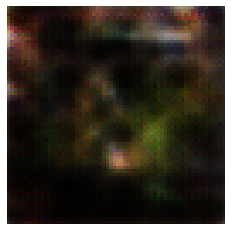

label = cat (3)
Calculated label by D = fake (10) -> Prob = 59.0

Image 14


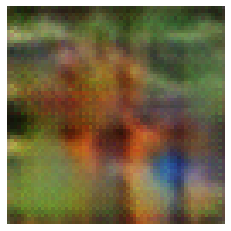

label = deer (4)
Calculated label by D = fake (10) -> Prob = 74.5

Image 15


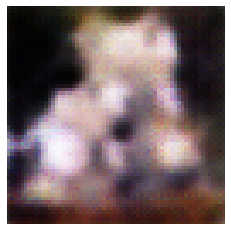

label = dog (5)
Calculated label by D = fake (10) -> Prob = 57.8

Image 16


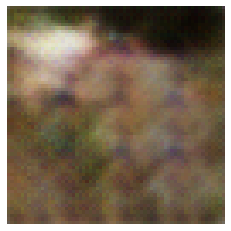

label = frog (6)
Calculated label by D = fake (10) -> Prob = 49.9

Image 17


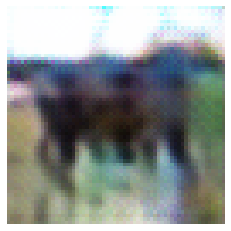

label = horse (7)
Calculated label by D = fake (10) -> Prob = 57.8

Image 18


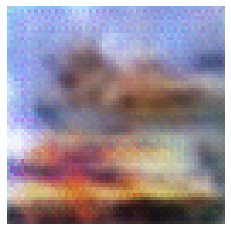

label = ship (8)
Calculated label by D = fake (10) -> Prob = 80.6

Image 19


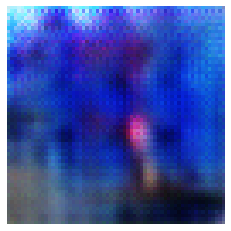

label = truck (9)
Calculated label by D = plane (0) -> Prob = 100.0
LR is set to 0.001
LR is set to 0.001




Image 0


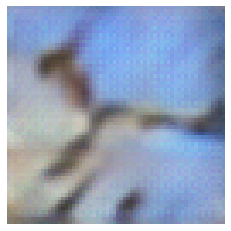

label = plane (0)
Calculated label by D = fake (10) -> Prob = 58.0

Image 1


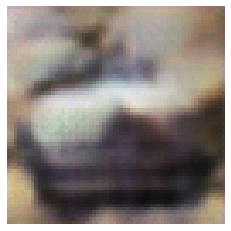

label = car (1)
Calculated label by D = fake (10) -> Prob = 36.9

Image 2


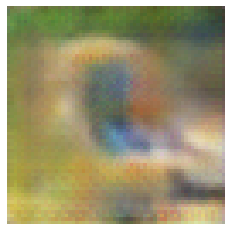

label = bird (2)
Calculated label by D = fake (10) -> Prob = 52.1

Image 3


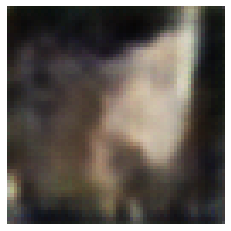

label = cat (3)
Calculated label by D = bird (2) -> Prob = 28.4

Image 4


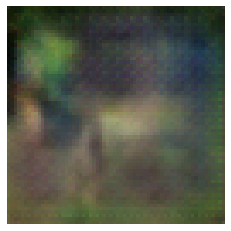

label = deer (4)
Calculated label by D = deer (4) -> Prob = 29.1

Image 5


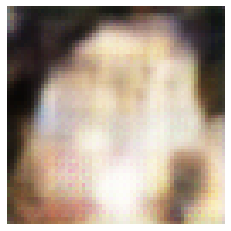

label = dog (5)
Calculated label by D = dog (5) -> Prob = 31.7

Image 6


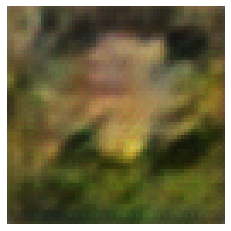

label = frog (6)
Calculated label by D = frog (6) -> Prob = 36.6

Image 7


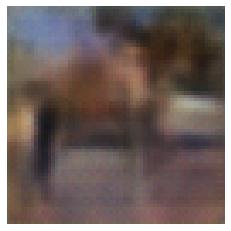

label = horse (7)
Calculated label by D = fake (10) -> Prob = 43.5

Image 8


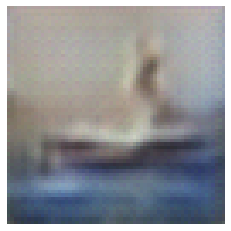

label = ship (8)
Calculated label by D = fake (10) -> Prob = 36.5

Image 9


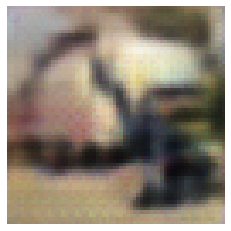

label = truck (9)
Calculated label by D = truck (9) -> Prob = 46.1

Image 10


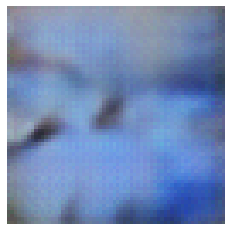

label = plane (0)
Calculated label by D = fake (10) -> Prob = 30.6

Image 11


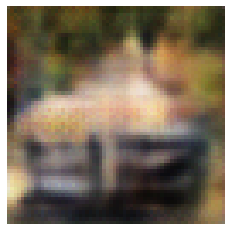

label = car (1)
Calculated label by D = car (1) -> Prob = 39.5

Image 12


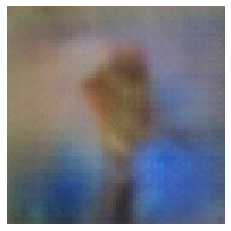

label = bird (2)
Calculated label by D = fake (10) -> Prob = 48.7

Image 13


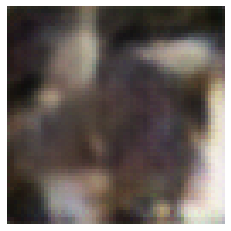

label = cat (3)
Calculated label by D = cat (3) -> Prob = 28.9

Image 14


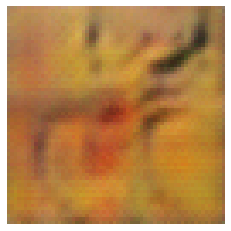

label = deer (4)
Calculated label by D = fake (10) -> Prob = 44.4

Image 15


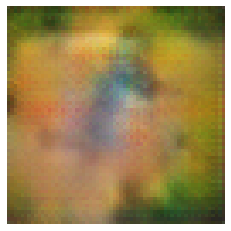

label = dog (5)
Calculated label by D = fake (10) -> Prob = 64.7

Image 16


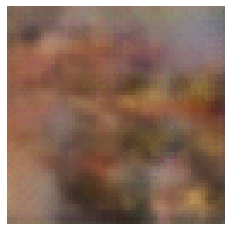

label = frog (6)
Calculated label by D = fake (10) -> Prob = 33.0

Image 17


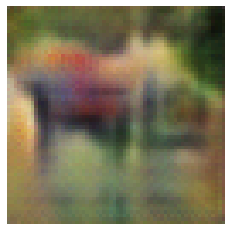

label = horse (7)
Calculated label by D = horse (7) -> Prob = 54.1

Image 18


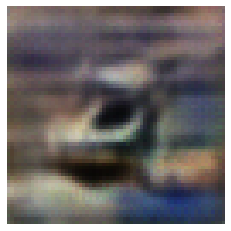

label = ship (8)
Calculated label by D = fake (10) -> Prob = 35.2

Image 19


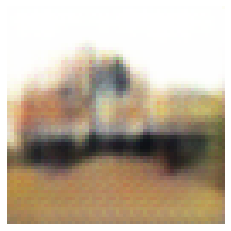

label = truck (9)
Calculated label by D = truck (9) -> Prob = 61.6
LR is set to 0.001
LR is set to 0.001




Image 0


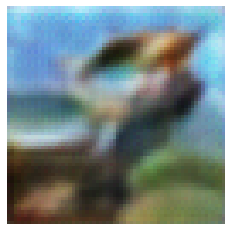

label = plane (0)
Calculated label by D = fake (10) -> Prob = 76.7

Image 1


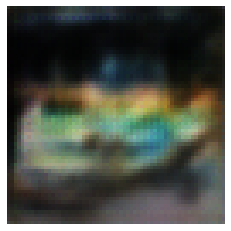

label = car (1)
Calculated label by D = fake (10) -> Prob = 93.0

Image 2


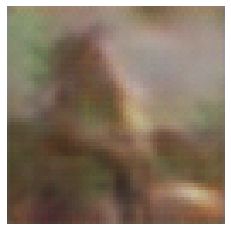

label = bird (2)
Calculated label by D = fake (10) -> Prob = 57.4

Image 3


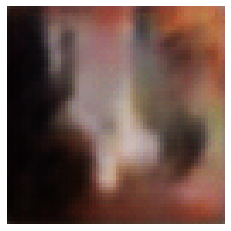

label = cat (3)
Calculated label by D = fake (10) -> Prob = 65.8

Image 4


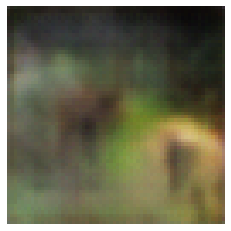

label = deer (4)
Calculated label by D = fake (10) -> Prob = 59.8

Image 5


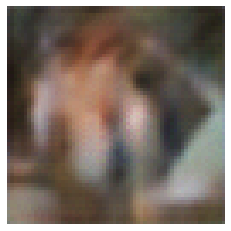

label = dog (5)
Calculated label by D = fake (10) -> Prob = 34.2

Image 6


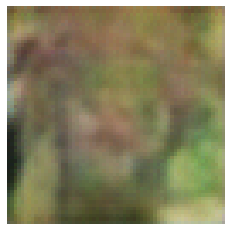

label = frog (6)
Calculated label by D = fake (10) -> Prob = 24.7

Image 7


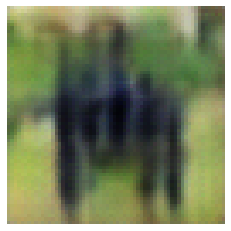

label = horse (7)
Calculated label by D = fake (10) -> Prob = 44.3

Image 8


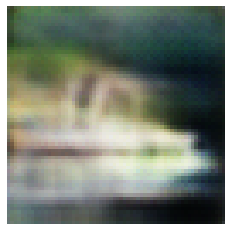

label = ship (8)
Calculated label by D = fake (10) -> Prob = 92.3

Image 9


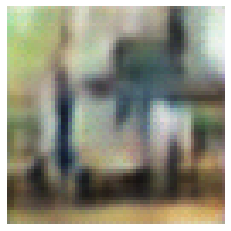

label = truck (9)
Calculated label by D = fake (10) -> Prob = 67.9

Image 10


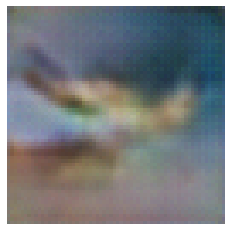

label = plane (0)
Calculated label by D = fake (10) -> Prob = 88.8

Image 11


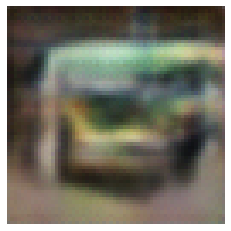

label = car (1)
Calculated label by D = fake (10) -> Prob = 64.1

Image 12


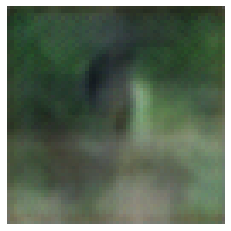

label = bird (2)
Calculated label by D = fake (10) -> Prob = 63.4

Image 13


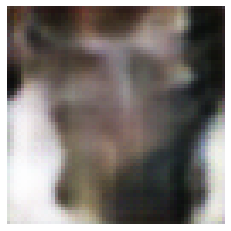

label = cat (3)
Calculated label by D = fake (10) -> Prob = 38.4

Image 14


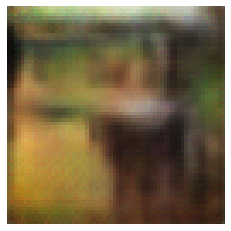

label = deer (4)
Calculated label by D = fake (10) -> Prob = 62.0

Image 15


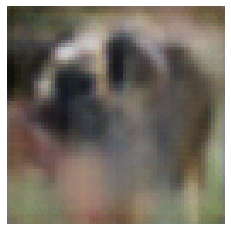

label = dog (5)
Calculated label by D = fake (10) -> Prob = 30.4

Image 16


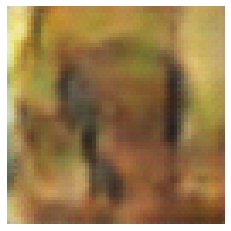

label = frog (6)
Calculated label by D = fake (10) -> Prob = 42.1

Image 17


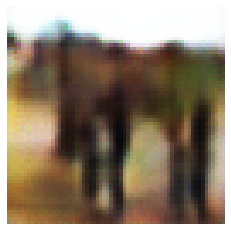

label = horse (7)
Calculated label by D = fake (10) -> Prob = 74.2

Image 18


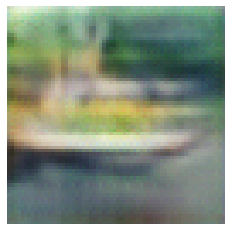

label = ship (8)
Calculated label by D = fake (10) -> Prob = 89.4

Image 19


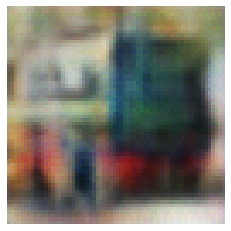

label = truck (9)
Calculated label by D = fake (10) -> Prob = 81.5
LR is set to 0.001
LR is set to 0.001


In [0]:
d_loss_l, g_loss_l = net.train(trainloader_CIFAR10, None, epochs=100)

In [0]:
# Reloading net
znet = zNet(110, 1, 1024)
clsnet = clsNet(16384, 10)
dec = Dec()
gen = Enc()
G = Generator(test_znet, test_dec)
D = Discriminator(test_clsnet, test_gen)

G.load_state_dict(torch.load("gdrive/My Drive/Colab Notebooks/artgan/CIFAR10_net/nn_G_13.pt"))
G.train()

D.load_state_dict(torch.load("gdrive/My Drive/Colab Notebooks/artgan/CIFAR10_net/nn_D_13.pt"))
D.train()

In [0]:
net_again = ArtGAN(G=G, D=D)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net_again.cuda()

using cuda


In [0]:
summary(net_again.G, input_size=(110, 1 ,1), batch_size=64)
summary(net_again.D, input_size=(3, 64 ,64), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [64, 1024, 4, 4]       1,803,264
       BatchNorm2d-2           [64, 1024, 4, 4]           2,048
              zNet-3           [64, 1024, 4, 4]               0
   ConvTranspose2d-4            [64, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [64, 512, 8, 8]           1,024
   ConvTranspose2d-6          [64, 256, 16, 16]       2,097,408
       BatchNorm2d-7          [64, 256, 16, 16]             512
   ConvTranspose2d-8          [64, 128, 32, 32]         524,416
       BatchNorm2d-9          [64, 128, 32, 32]             256
  ConvTranspose2d-10          [64, 128, 32, 32]         147,584
      BatchNorm2d-11          [64, 128, 32, 32]             256
  ConvTranspose2d-12            [64, 3, 64, 64]           6,147
              Dec-13            [64, 3, 64, 64]               0
Total params: 12,972,035
Trainable para

LR is set to 0.001
LR is set to 0.001




Image 0


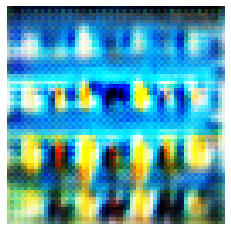

label = plane (0)
Calculated label by D = fake (10) -> Prob = 97.2

Image 1


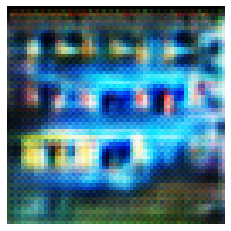

label = car (1)
Calculated label by D = fake (10) -> Prob = 98.2

Image 2


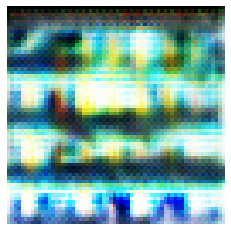

label = bird (2)
Calculated label by D = fake (10) -> Prob = 97.6

Image 3


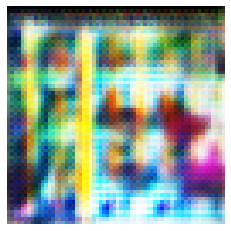

label = cat (3)
Calculated label by D = fake (10) -> Prob = 96.8

Image 4


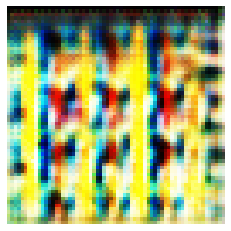

label = deer (4)
Calculated label by D = fake (10) -> Prob = 97.2

Image 5


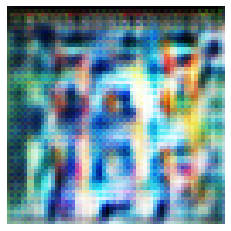

label = dog (5)
Calculated label by D = fake (10) -> Prob = 98.7

Image 6


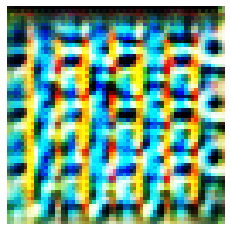

label = frog (6)
Calculated label by D = fake (10) -> Prob = 99.4

Image 7


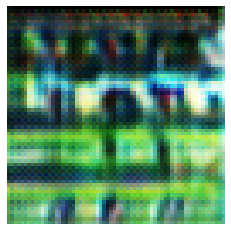

label = horse (7)
Calculated label by D = fake (10) -> Prob = 98.5

Image 8


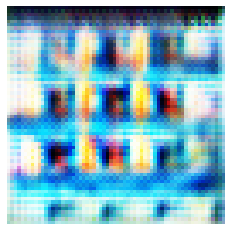

label = ship (8)
Calculated label by D = fake (10) -> Prob = 99.2

Image 9


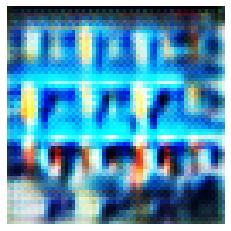

label = truck (9)
Calculated label by D = fake (10) -> Prob = 97.2

Image 10


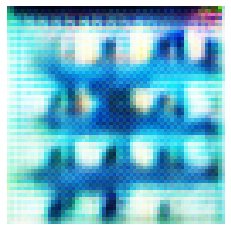

label = plane (0)
Calculated label by D = fake (10) -> Prob = 99.2

Image 11


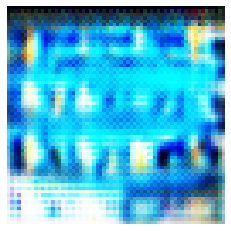

label = car (1)
Calculated label by D = fake (10) -> Prob = 90.1

Image 12


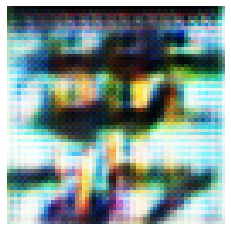

label = bird (2)
Calculated label by D = fake (10) -> Prob = 93.5

Image 13


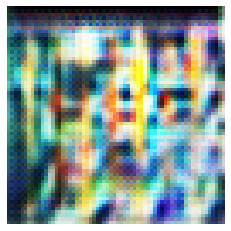

label = cat (3)
Calculated label by D = fake (10) -> Prob = 95.9

Image 14


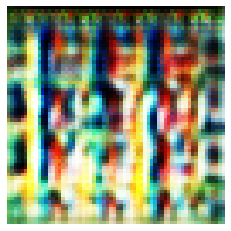

label = deer (4)
Calculated label by D = fake (10) -> Prob = 99.6

Image 15


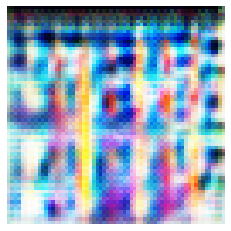

label = dog (5)
Calculated label by D = fake (10) -> Prob = 98.6

Image 16


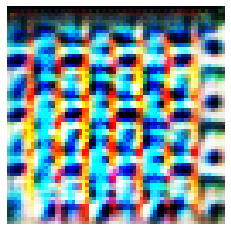

label = frog (6)
Calculated label by D = fake (10) -> Prob = 99.8

Image 17


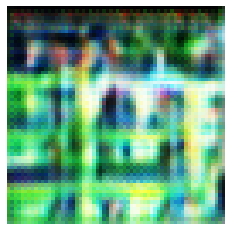

label = horse (7)
Calculated label by D = fake (10) -> Prob = 93.8

Image 18


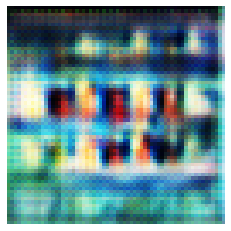

label = ship (8)
Calculated label by D = fake (10) -> Prob = 98.9

Image 19


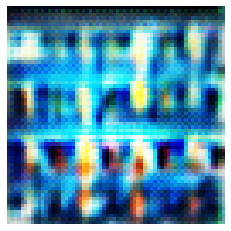

label = truck (9)
Calculated label by D = fake (10) -> Prob = 96.6
LR is set to 0.001
LR is set to 0.001


In [0]:
d_loss_l, g_loss_l = net_again.train(trainloader_CIFAR10, None, epochs=100, initial_epoch=14)